# Deep Neural Network for Fraud Detection: Application

## Packages

In [60]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
#from dnn_app_utils_v3 import *
import csv
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict


%load_ext autoreload 
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

The data for credit card fraud detection is from: 
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [61]:
d = pd.read_csv("./creditcardfraud/creditcard.csv").values 
 
train = d[0:284800,:] 
test = d[284800:,:] 
train_x_orig = train[:,0:30] 
train_y = train[:,-1] 
test_x_orig = test[:,0:30] 
test_y = test[:,-1] 

In [62]:
# Explore your dataset  
m_train = train_x_orig.shape[0] 
m_test = test_x_orig.shape[0] 
 
print ("Number of training examples: " + str(m_train)) 
print ("Number of testing examples: " + str(m_test)) 
 
print ("train_x_orig shape: " + str(train_x_orig.shape)) 
print ("train_y shape: " + str(train_y.shape)) 
print ("test_x_orig shape: " + str(test_x_orig.shape)) 
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 284800
Number of testing examples: 7
train_x_orig shape: (284800, 30)
train_y shape: (284800,)
test_x_orig shape: (7, 30)
test_y shape: (7,)


In [63]:
# Reshape the training and test examples  
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions 
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T 
train_y_flatten = train_y.reshape(train_y.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions 
test_y_flatten = test_y.reshape(test_y.shape[0], -1).T 
 
X_train = train_x_flatten 
Y_train = train_y_flatten 
X_test = test_x_flatten 
Y_test = test_y_flatten 
 
Y_train = convert_to_one_hot(Y_train.astype(int), 2) 
Y_test = convert_to_one_hot(Y_test.astype(int), 2) 
 
print ("number of training examples = " + str(X_train.shape[1])) 
print ("number of test examples = " + str(X_test.shape[1])) 
print ("X_train shape: " + str(X_train.shape)) 
print ("Y_train shape: " + str(Y_train.shape)) 
print ("X_test shape: " + str(X_test.shape)) 
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 284800
number of test examples = 7
X_train shape: (30, 284800)
Y_train shape: (2, 284800)
X_test shape: (30, 7)
Y_test shape: (2, 7)


## Tensorflow Neural Network

In [64]:
def create_placeholders(n_x, n_y): 
    """ 
    Creates the placeholders for the tensorflow session. 
     
    Arguments: 
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288) 
    n_y -- scalar, number of classes (from 0 to 5, so -> 6) 
     
    Returns: 
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float" 
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float" 
     
    Tips: 
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders. 
      In fact, the number of examples during test/train is different. 
    """ 
 
 
    X = tf.placeholder(tf.float32, [n_x,None]) 
    Y = tf.placeholder(tf.float32, [n_y,None]) 
     
    return X, Y

In [65]:
X, Y = create_placeholders(30, 2) 
print ("X = " + str(X)) 
print ("Y = " + str(Y))

X = Tensor("Placeholder_3:0", shape=(30, ?), dtype=float32)
Y = Tensor("Placeholder_4:0", shape=(2, ?), dtype=float32)


In [66]:
def initialize_parameters(): 
    """ 
    Initializes parameters to build a neural network with tensorflow. The shapes are: 
                        W1 : [25, 12288] 
                        b1 : [25, 1] 
                        W2 : [12, 25] 
                        b2 : [12, 1] 
                        W3 : [6, 12] 
                        b3 : [6, 1] 
     
    Returns: 
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3 
    """ 
     
    tf.set_random_seed(1)              
         
    W1 = tf.get_variable("W1", [25,30], initializer = tf.contrib.layers.xavier_initializer(seed = 1)) 
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer()) 
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1)) 
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer()) 
    W3 = tf.get_variable("W3", [2,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1)) 
    b3 = tf.get_variable("b3", [2,1], initializer = tf.zeros_initializer()) 
 
    parameters = {"W1": W1, 
                  "b1": b1, 
                  "W2": W2, 
                  "b2": b2, 
                  "W3": W3, 
                  "b3": b3} 
     
    return parameters

In [67]:
tf.reset_default_graph() 
with tf.Session() as sess: 
    parameters = initialize_parameters() 
    print("W1 = " + str(parameters["W1"])) 
    print("b1 = " + str(parameters["b1"])) 
    print("W2 = " + str(parameters["W2"])) 
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 30) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [68]:
def forward_propagation(X, parameters): 
    """ 
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX 
     
    Arguments: 
    X -- input dataset placeholder, of shape (input size, number of examples) 
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3" 
                  the shapes are given in initialize_parameters 
 
    Returns: 
    Z3 -- the output of the last LINEAR unit 
    """ 
     
    # Retrieve the parameters from the dictionary "parameters"  
    W1 = parameters['W1'] 
    b1 = parameters['b1'] 
    W2 = parameters['W2'] 
    b2 = parameters['b2'] 
    W3 = parameters['W3'] 
    b3 = parameters['b3'] 
     
    #                                                                   # Numpy Equivalents: 
    Z1 = tf.add(tf.matmul(W1,X),b1)                                     # Z1 = np.dot(W1, X) + b1 
    A1 = tf.nn.relu(Z1)                                                 # A1 = relu(Z1) 
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                    # Z2 = np.dot(W2, a1) + b2 
    A2 = tf.nn.relu(Z2)                                                 # A2 = relu(Z2) 
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                    # Z3 = np.dot(W3,Z2) + b3 
     
    return Z3

In [69]:
tf.reset_default_graph() 
 
with tf.Session() as sess: 
    X, Y = create_placeholders(30, 2) 
    parameters = initialize_parameters() 
    Z3 = forward_propagation(X, parameters) 
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(2, ?), dtype=float32)


In [70]:
def compute_cost(Z3, Y): 
    """ 
    Computes the cost 
     
    Arguments: 
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples) 
    Y -- "true" labels vector placeholder, same shape as Z3 
     
    Returns: 
    cost - Tensor of the cost function 
    """ 
     
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...) 
    logits = tf.transpose(Z3) 
    labels = tf.transpose(Y) 
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels)) 
     
    return cost

In [71]:
tf.reset_default_graph() 
 
with tf.Session() as sess: 
    X, Y = create_placeholders(30, 2) 
    parameters = initialize_parameters() 
    Z3 = forward_propagation(X, parameters) 
    cost = compute_cost(Z3, Y) 
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [35]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, 
          num_epochs = 1500, minibatch_size = 32, print_cost = True): 
    """ 
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX. 
     
    Arguments: 
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080) 
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080) 
    X_test -- training set, of shape (input size = 12288, number of training examples = 120) 
    Y_test -- test set, of shape (output size = 6, number of test examples = 120) 
    learning_rate -- learning rate of the optimization 
    num_epochs -- number of epochs of the optimization loop 
    minibatch_size -- size of a minibatch 
    print_cost -- True to print the cost every 100 epochs 
     
    Returns: 
    parameters -- parameters learnt by the model. They can then be used to predict. 
    """ 
     
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables 
    tf.set_random_seed(1)                             # to keep consistent results 
    seed = 3                                          # to keep consistent results 
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set) 
    n_y = Y_train.shape[0]                            # n_y : output size 
    costs = []                                        # To keep track of the cost 
     
    # Create Placeholders of shape (n_x, n_y) 
    X, Y = create_placeholders(n_x, n_y) 
    
    # Initialize parameters 
    parameters = initialize_parameters() 
     
    # Forward propagation: Build the forward propagation in the tensorflow graph 
    Z3 = forward_propagation(X, parameters) 
     
    # Cost function: Add cost function to tensorflow graph 
    cost = compute_cost(Z3, Y) 
     
    # Backpropagation: Define the tensorflow optimizer. Using AdamOptimizer. 
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost) 
     
    # Initialize all the variables 
    init = tf.global_variables_initializer() 
    
    # Saver for model
    saver = tf.train.Saver()
 
    # Start the session to compute the tensorflow graph 
    with tf.Session() as sess: 
         
        # Run the initialization 
        sess.run(init) 
         
        # Do the training loop 
        for epoch in range(num_epochs): 
 
            epoch_cost = 0.                       # Defines a cost related to an epoch 
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set 
            seed = seed + 1 
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed) 
 
            for minibatch in minibatches: 
 
                # Select a minibatch 
                (minibatch_X, minibatch_Y) = minibatch 
                 
                # IMPORTANT: The line that runs the graph on a minibatch. 
                # Run the session to execute the "optimizer" and the "cost",  
                # the feedict should contain a minibatch for (X,Y). 
                _ , minibatch_cost = sess.run([optimizer,cost], feed_dict = {X:minibatch_X, Y: minibatch_Y}) 
                epoch_cost += minibatch_cost / num_minibatches 
 
            # Print the cost every epoch 
            if print_cost == True and epoch % 100 == 0: 
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost)) 
            if print_cost == True and epoch % 5 == 0: 
                costs.append(epoch_cost) 
                 
        # plot the cost 
        plt.plot(np.squeeze(costs)) 
        plt.ylabel('cost') 
        plt.xlabel('iterations (per tens)') 
        plt.title("Learning rate =" + str(learning_rate)) 
        plt.show() 
 
        # lets save the parameters in a variable 
        parameters = sess.run(parameters) 
        print ("Parameters have been trained!") 
 
        # Calculate the correct predictions 
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y)) 
 
        # Calculate accuracy on the test set 
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 
 
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train})) 
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test})) 
     
        saver.save(sess, './my_test_model') 
         
        return parameters


Cost after epoch 0: 141.974387
Cost after epoch 100: 0.010604
Cost after epoch 200: 0.005083
Cost after epoch 300: 0.004907
Cost after epoch 400: 0.004178
Cost after epoch 500: 0.004226
Cost after epoch 600: 0.005543
Cost after epoch 700: 0.004129
Cost after epoch 800: 0.004085
Cost after epoch 900: 0.005123
Cost after epoch 1000: 0.004172
Cost after epoch 1100: 0.004453
Cost after epoch 1200: 0.004803
Cost after epoch 1300: 0.004466
Cost after epoch 1400: 0.004945


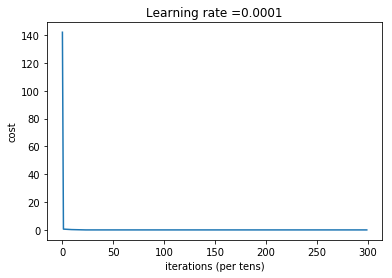

Parameters have been trained!
Train Accuracy: 0.9991573
Test Accuracy: 1.0


In [37]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [72]:
print(X_test[:,1:2].shape)
prediction = predict(X_test[:,1:2], parameters) 
print(prediction) 
print(Y_test[:,1:2])

(30, 1)


ValueError: Dimensions must be equal, but are 30 and 12288 for 'MatMul_3' (op: 'MatMul') with input shapes: [25,30], [12288,30].